In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [2]:
df = pd.read_csv("/content/Food_Delivery_Times.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


# Data Understanding

This dataset is designed for predicting food delivery times based on various influencing factors such as distance, weather, traffic conditions, and time of day. It offers a practical and engaging challenge for machine learning practitioners, especially those interested in logistics and operations research.

Key Features:

Order_ID: Unique identifier for each order.

Distance_km: The delivery distance in kilometers.

Weather: Weather conditions during the delivery, including Clear, Rainy, Snowy, Foggy, and Windy.

Traffic_Level: Traffic conditions categorized as Low, Medium, or High.

Time_of_Day: The time when the delivery took place, categorized as Morning, Afternoon, Evening, or Night.

Vehicle_Type: Type of vehicle used for delivery, including Bike, Scooter, and Car.

Preparation_Time_min: The time required to prepare the order, measured in minutes.

Courier_Experience_yrs: Experience of the courier in years.

Delivery_Time_min: The total delivery time in minutes (target variable).

# Problem Statement

1. Bagaimana cara memprediksi lama waktu pengantaran makanan (Delivery_Time_min) dengan akurasi tinggi berdasarkan faktor jarak, cuaca, lalu lintas, waktu pengantaran, jenis kendaraan, waktu persiapan, dan pengalaman kurir?

2. Faktor-faktor mana yang paling signifikan mempengaruhi waktu pengantaran, dan bagaimana informasi tersebut dapat digunakan untuk meningkatkan efisiensi layanan food delivery?

# Data Preprocessing

In [3]:
df.isnull().sum()

,0
Order_ID,0
Distance_km,0
Weather,30
Traffic_Level,30
Time_of_Day,30
Vehicle_Type,0
Preparation_Time_min,0
Courier_Experience_yrs,30
Delivery_Time_min,0


In [4]:
df['Weather'] = df['Weather'].fillna(df['Weather'].mode()[0])
df['Traffic_Level'] = df['Traffic_Level'].fillna(df['Traffic_Level'].mode()[0])
df['Time_of_Day'] = df['Time_of_Day'].fillna(df['Time_of_Day'].mode()[0])

df['Courier_Experience_yrs'] = df['Courier_Experience_yrs'].fillna(df['Courier_Experience_yrs'].median())

In [5]:
df.isnull().sum()

,0
Order_ID,0
Distance_km,0
Weather,0
Traffic_Level,0
Time_of_Day,0
Vehicle_Type,0
Preparation_Time_min,0
Courier_Experience_yrs,0
Delivery_Time_min,0


# EDA

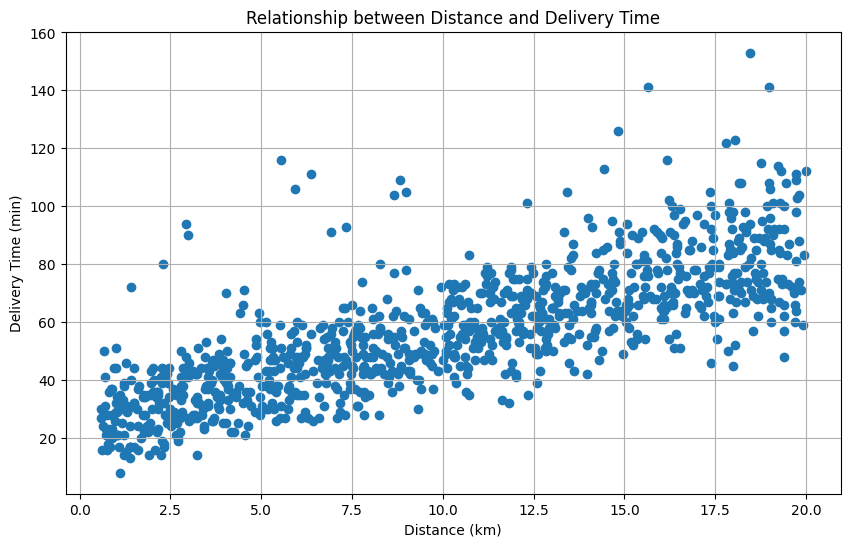

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Distance_km'], df['Delivery_Time_min'])
plt.xlabel('Distance (km)')
plt.ylabel('Delivery Time (min)')
plt.title('Relationship between Distance and Delivery Time')
plt.grid(True)
plt.show()

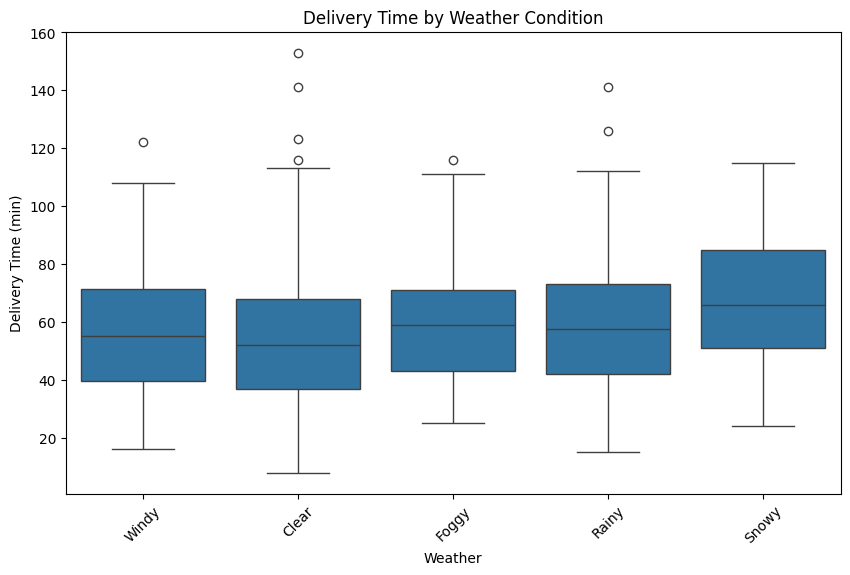

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Weather', y='Delivery_Time_min', data=df)
plt.xlabel('Weather')
plt.ylabel('Delivery Time (min)')
plt.title('Delivery Time by Weather Condition')
plt.xticks(rotation=45)
plt.show()

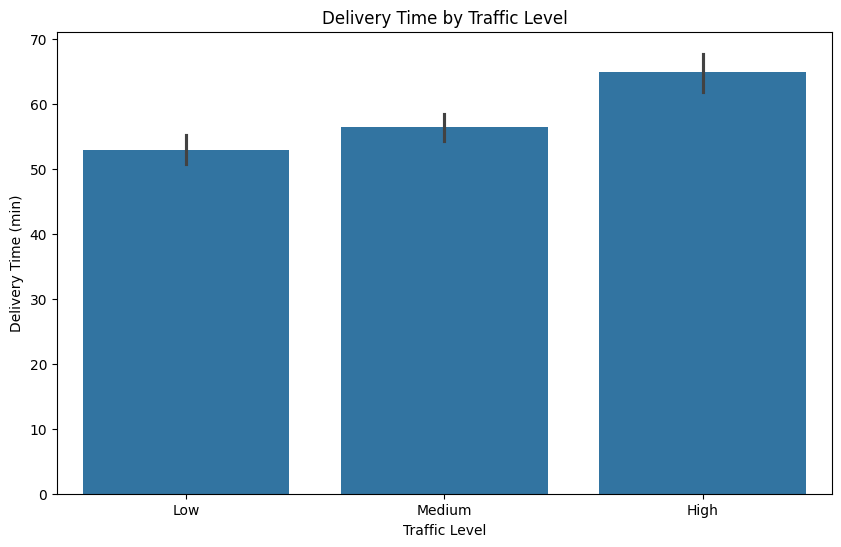

In [8]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Traffic_Level', y='Delivery_Time_min', data=df)
plt.xlabel('Traffic Level')
plt.ylabel('Delivery Time (min)')
plt.title('Delivery Time by Traffic Level')
plt.show()

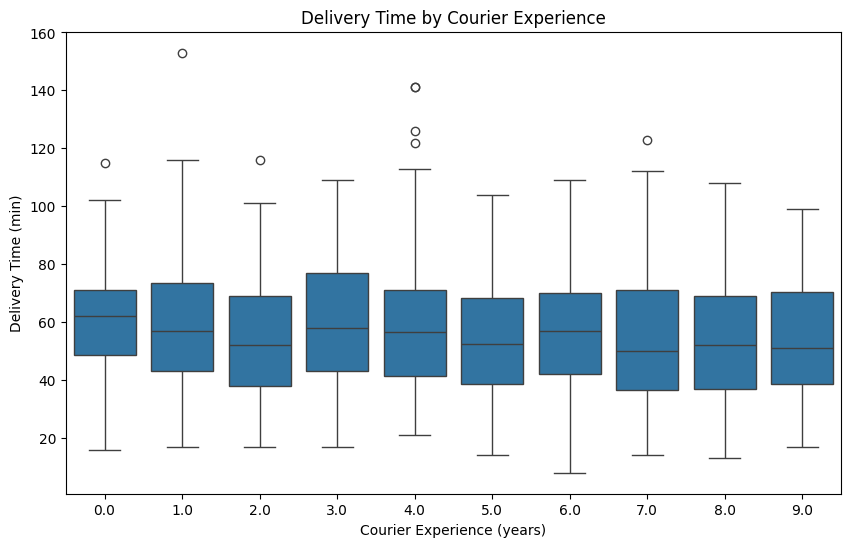

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Courier_Experience_yrs', y='Delivery_Time_min', data=df)
plt.xlabel('Courier Experience (years)')
plt.ylabel('Delivery Time (min)')
plt.title('Delivery Time by Courier Experience')
plt.show()

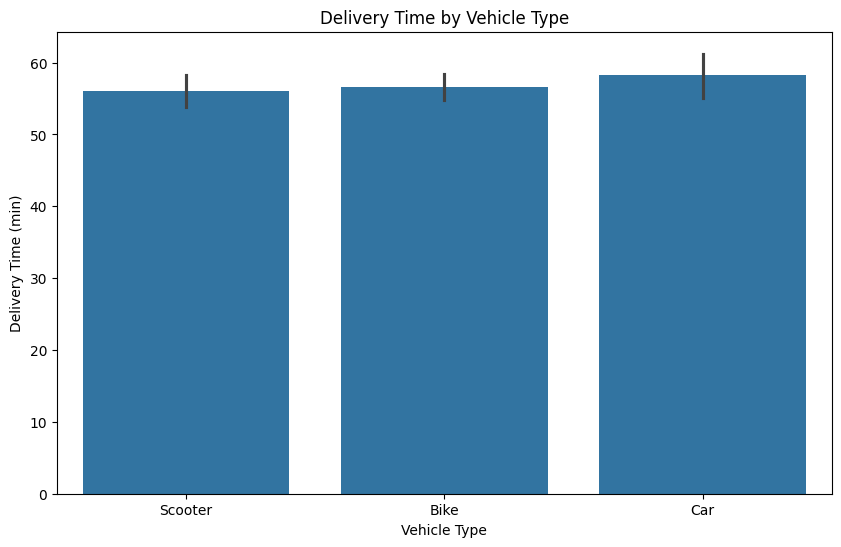

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Vehicle_Type', y='Delivery_Time_min', data=df)
plt.xlabel('Vehicle Type')
plt.ylabel('Delivery Time (min)')
plt.title('Delivery Time by Vehicle Type')
plt.show()

In [11]:
num_cols = ["Distance_km", "Preparation_Time_min", "Courier_Experience_yrs", "Delivery_Time_min"]
cat_cols = ["Weather", "Traffic_Level", "Time_of_Day", "Vehicle_Type"]

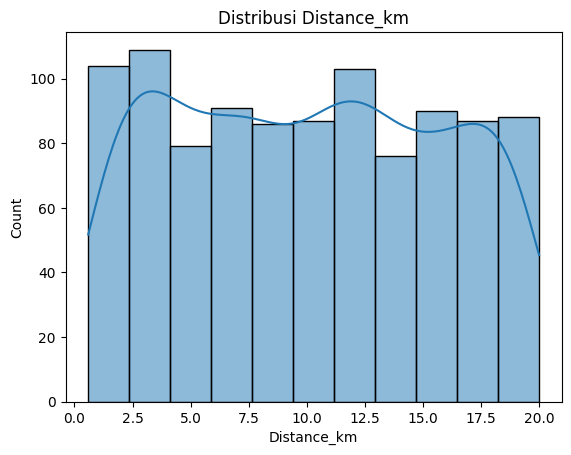

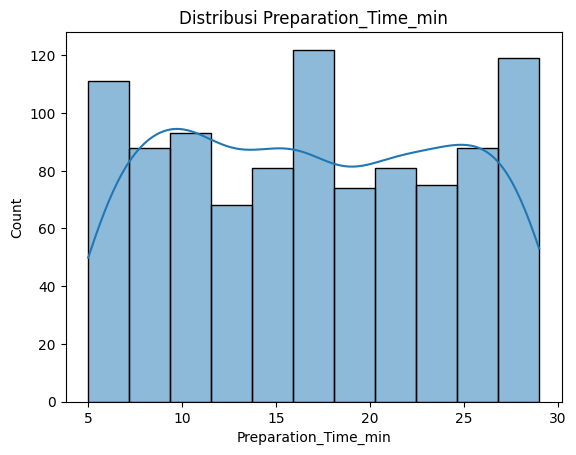

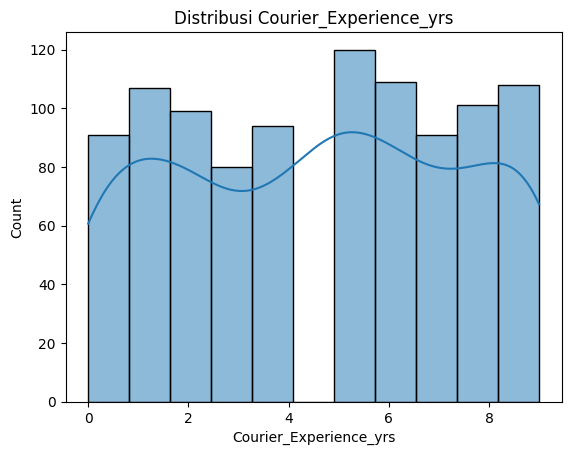

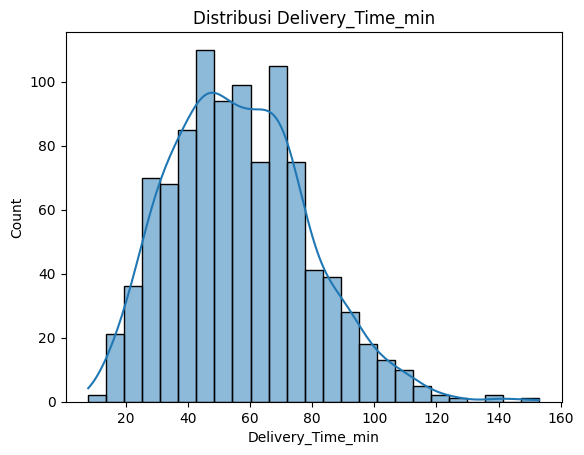

In [12]:
for c in num_cols:
    fig, ax = plt.subplots()
    sns.histplot(df[c], kde=True, ax=ax)
    ax.set_title(f"Distribusi {c}")
    ax.set_xlabel(c)
    plt.show()

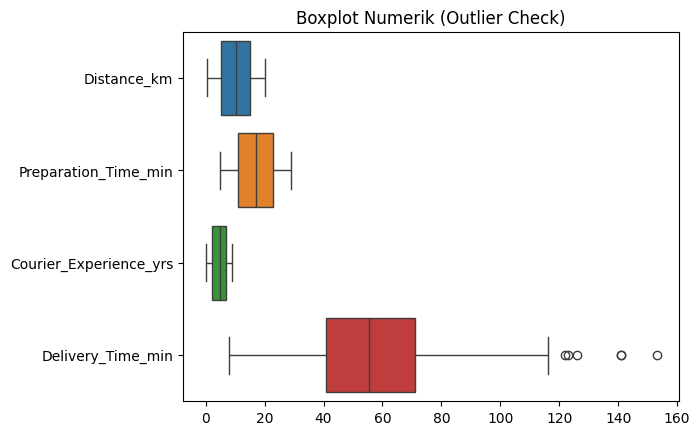

In [13]:
fig, ax = plt.subplots()
sns.boxplot(data=df[num_cols], orient='h', ax=ax)
ax.set_title("Boxplot Numerik (Outlier Check)")
plt.show()

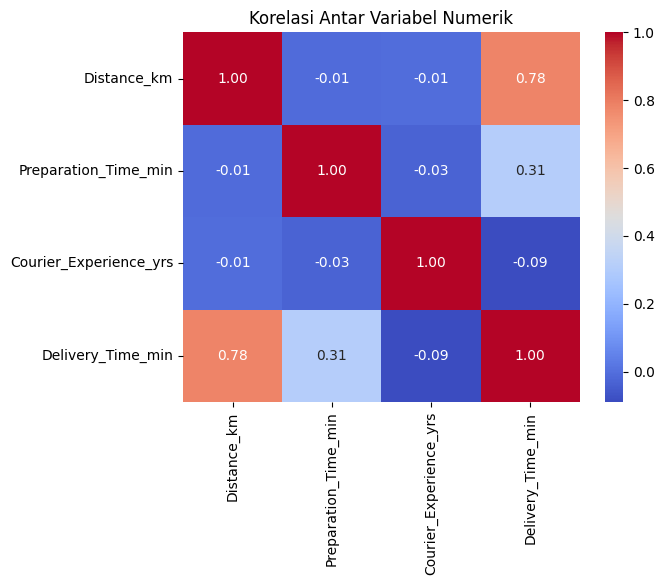

In [14]:
corr = df[num_cols].corr()
fig, ax = plt.subplots()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)
ax.set_title("Korelasi Antar Variabel Numerik")
plt.show()

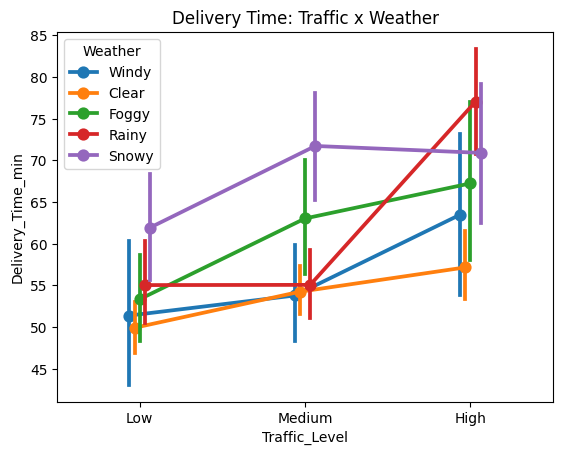

In [15]:
fig, ax = plt.subplots()
sns.pointplot(data=df, x="Traffic_Level", y="Delivery_Time_min", hue="Weather", dodge=True, ax=ax)
ax.set_title("Delivery Time: Traffic x Weather")
plt.show()

In [16]:
#    a) Top 10 kombinasi Time_of_Day x Traffic dengan rata2 waktu tertinggi
summary_a = (
    df.groupby(["Time_of_Day","Traffic_Level"])["Delivery_Time_min"]
      .mean().sort_values(ascending=False).head(10).reset_index()
)
print("Top kombinasi Time_of_Day x Traffic (rata-rata Delivery tertinggi):")
display(summary_a)

#    b) Perbandingan rata2 & IQR per Weather
def iqr(x): return np.percentile(x,75) - np.percentile(x,25)
summary_b = df.groupby("Weather")["Delivery_Time_min"].agg(['count','mean','median',iqr]).sort_values("mean", ascending=False)
print("Ringkasan Weather → Delivery_Time:")
display(summary_b)

Top kombinasi Time_of_Day x Traffic (rata-rata Delivery tertinggi):


,Time_of_Day,Traffic_Level,Delivery_Time_min
0,Night,High,65.833333
1,Morning,High,65.227273
2,Evening,High,64.581818
3,Afternoon,High,64.224138
4,Afternoon,Medium,57.299065
5,Evening,Medium,57.232558
6,Morning,Medium,56.444444
7,Evening,Low,54.192661
8,Morning,Low,53.414062
9,Night,Low,53.333333


Ringkasan Weather → Delivery_Time:


,count,mean,median,iqr
Weather,,,,
Snowy,97,67.113402,66.0,34.0
Rainy,204,59.794118,57.5,31.0
Foggy,103,59.466019,59.0,28.0
Windy,96,55.458333,55.0,31.5
Clear,500,53.150000,52.0,31.0


# Modelling

In [17]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.inspection import permutation_importance

# Feature / Target
X = df.drop(columns=["Order_ID", "Delivery_Time_min"])
y = df["Delivery_Time_min"]

# Kolom numerik & kategorikal
num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
print("Numerical:", num_cols)
print("Categorical:", cat_cols)

Numerical: ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']
Categorical: ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']


In [18]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [19]:
def rmse_func(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse_func, greater_is_better=False)

## Random Forest

### Baseline

In [20]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)
pipe_rf = Pipeline([("preprocessor", preprocessor), ("model", rf)])

In [21]:
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Distance_km',
                                                   'Preparation_Time_min',
                                                   'Courier_Experience_yrs']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Weather', 'Traffic_Level',
                                                   'Time_of_Day',
                                                   'Vehicle_Type'])])),
                ('model',
                 RandomForestRegressor(n_estimators=400, n_jobs=-1,
                                       random_state=42))])

In [22]:
y_pred = pipe_rf.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = rmse_func(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
print("=== Random Forest (Baseline) — Test ===")
print(f"MAE : {mae:,.3f}  |  RMSE: {rmse:,.3f}  |  R²: {r2:,.3f}")

=== Random Forest (Baseline) — Test ===
MAE : 6.702  |  RMSE: 9.567  |  R²: 0.796


In [23]:
cv_scores = cross_val_score(pipe_rf, X_train, y_train, cv=5, scoring=rmse_scorer, n_jobs=-1)
print("CV RMSE mean:", (-cv_scores).mean().round(3), "| std:", (-cv_scores).std().round(3))

CV RMSE mean: 12.194 | std: 0.988


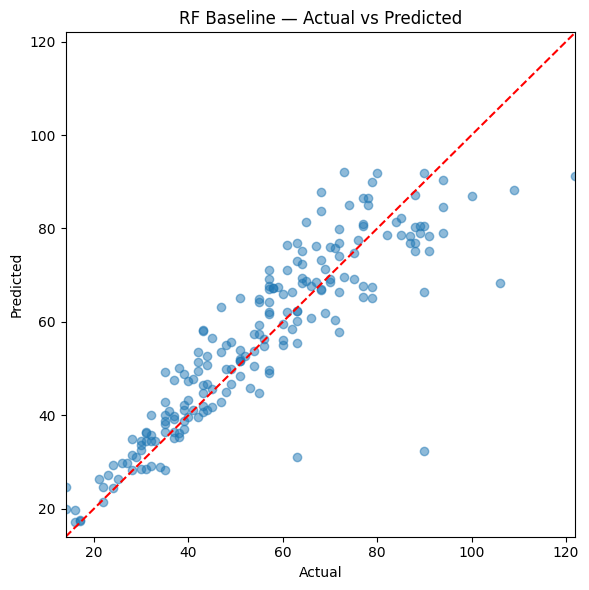

In [24]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--'); plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title("RF Baseline — Actual vs Predicted")
plt.tight_layout(); plt.show()

,feature,importance_mean,importance_std
0,Distance_km,1.307755,0.085542
1,Time_of_Day,0.215719,0.027939
2,Courier_Experience_yrs,0.051916,0.010234
3,Preparation_Time_min,0.034921,0.007494
4,Vehicle_Type,0.021220,0.003648
5,Weather,0.001427,0.004807
6,Traffic_Level,-0.000337,0.003160


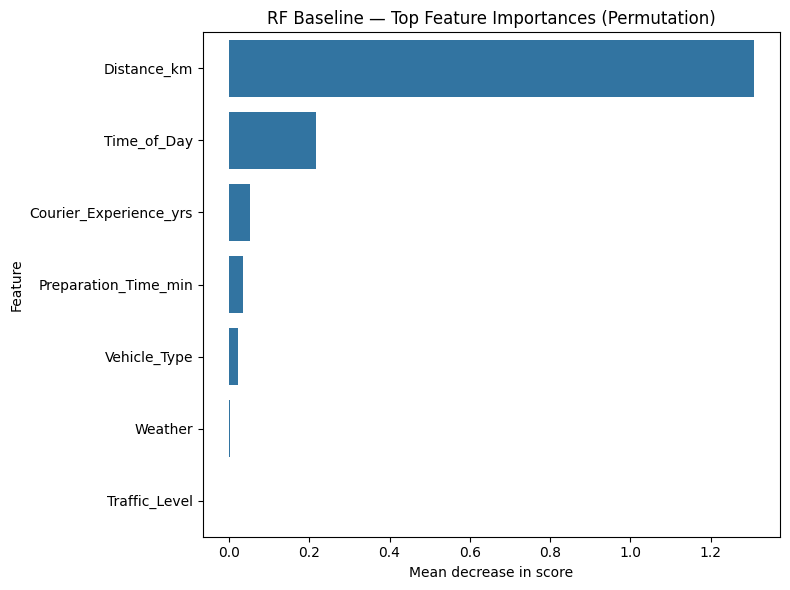

In [25]:
r = permutation_importance(pipe_rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
base_feature_names = num_cols + cat_cols
importances_rf_base = (pd.DataFrame({
    "feature": base_feature_names,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False).reset_index(drop=True))
display(importances_rf_base.head(15))

plt.figure(figsize=(8,6))
sns.barplot(data=importances_rf_base.head(15), x="importance_mean", y="feature")
plt.title("RF Baseline — Top Feature Importances (Permutation)")
plt.xlabel("Mean decrease in score"); plt.ylabel("Feature")
plt.tight_layout(); plt.show()

### Tuning

In [26]:
param_dist_rf = {
    "model__n_estimators":      [200, 400, 600, 800, 1000],
    "model__max_depth":         [None, 10, 20, 30],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf":  [1, 2, 4],
    "model__max_features":      ["sqrt", "log2", 1.0, 0.8],
    "model__bootstrap":         [True, False],
}

rf_randcv = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_dist_rf,
    n_iter=40,
    scoring=rmse_scorer,
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

In [27]:
rf_randcv.fit(X_train, y_train)
print("Best params (RF):", rf_randcv.best_params_)
print("Best CV RMSE (RF):", -rf_randcv.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params (RF): {'model__n_estimators': 800, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_features': 0.8, 'model__max_depth': None, 'model__bootstrap': True}
Best CV RMSE (RF): 11.802228376967765


In [28]:
best_rf = rf_randcv.best_estimator_
y_pred_best = best_rf.predict(X_test)
mae_b, rmse_b, r2_b = mean_absolute_error(
    y_test, y_pred_best), rmse_func(y_test, y_pred_best),
    r2_score(y_test, y_pred_best)
print("\n=== Random Forest (Tuned) — Test ===")
print(f"MAE : {mae_b:,.3f}  |  RMSE: {rmse_b:,.3f}  |  R²: {r2_b:,.3f}")


=== Random Forest (Tuned) — Test ===
MAE : 6.608  |  RMSE: 9.519  |  R²: 0.798


In [29]:
cv_scores_rf_best = cross_val_score(best_rf, X_train, y_train, cv=5, scoring=rmse_scorer, n_jobs=-1)
print("RF Tuned — CV RMSE mean:", (-cv_scores_rf_best).mean().round(3), "| std:", (-cv_scores_rf_best).std().round(3))

RF Tuned — CV RMSE mean: 11.802 | std: 0.895


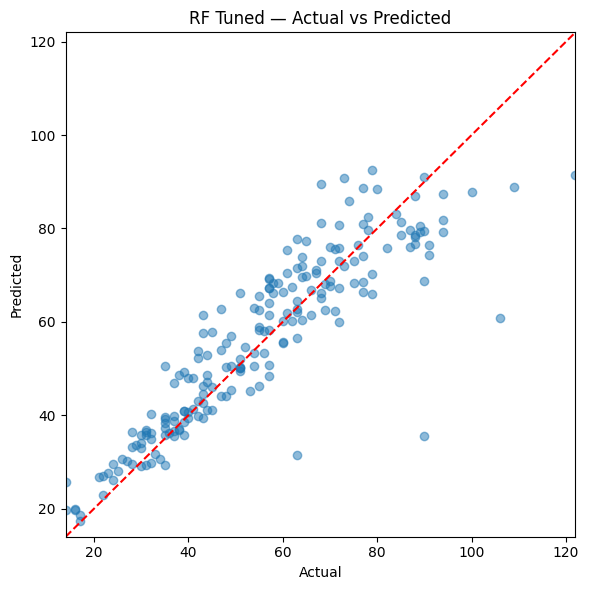

In [30]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
lims = [min(y_test.min(), y_pred_best.min()), max(y_test.max(), y_pred_best.max())]
plt.plot(lims, lims, 'r--'); plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title("RF Tuned — Actual vs Predicted")
plt.tight_layout(); plt.show()

In [31]:
r = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importances_rf_tuned = (pd.DataFrame({
    "feature": base_feature_names,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False).reset_index(drop=True))
display(importances_rf_tuned.head(15))

,feature,importance_mean,importance_std
0,Distance_km,1.285024,0.091467
1,Time_of_Day,0.207428,0.023988
2,Courier_Experience_yrs,0.046525,0.010578
3,Preparation_Time_min,0.030674,0.005354
4,Vehicle_Type,0.015432,0.003245
5,Weather,0.002368,0.001598
6,Traffic_Level,-0.000790,0.002510


## XGBoost

### Baseline

In [32]:
from xgboost import XGBRegressor

In [33]:
xgb = XGBRegressor(
    n_estimators=600, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    random_state=42, tree_method="hist", n_jobs=-1, use_label_encoder=False
)
pipe_xgb = Pipeline([("preprocessor", preprocessor), ("model", xgb)])

In [34]:
pipe_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Distance_km',
                                                   'Preparation_Time_min',
                                                   'Courier_Experience_yrs']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Weather', 'Traffic_Level',
                                                   'Time_of_Day',
                                                   'Vehicle_Type'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, c...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=600, n_jobs=-1,
                              num_parallel_tree=None, ...))])

In [35]:
y_pred = pipe_xgb.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = rmse_func(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
print("=== XGBoost (Baseline) — Test ===")
print(f"MAE : {mae:,.3f}  |  RMSE: {rmse:,.3f}  |  R²: {r2:,.3f}")

=== XGBoost (Baseline) — Test ===
MAE : 6.791  |  RMSE: 9.728  |  R²: 0.789


In [36]:
cv_scores_xgb = cross_val_score(pipe_xgb, X_train, y_train, cv=5, scoring=rmse_scorer, n_jobs=-1)
print("CV RMSE mean:", (-cv_scores_xgb).mean().round(3), "| std:", (-cv_scores_xgb).std().round(3))

CV RMSE mean: 12.266 | std: 0.843


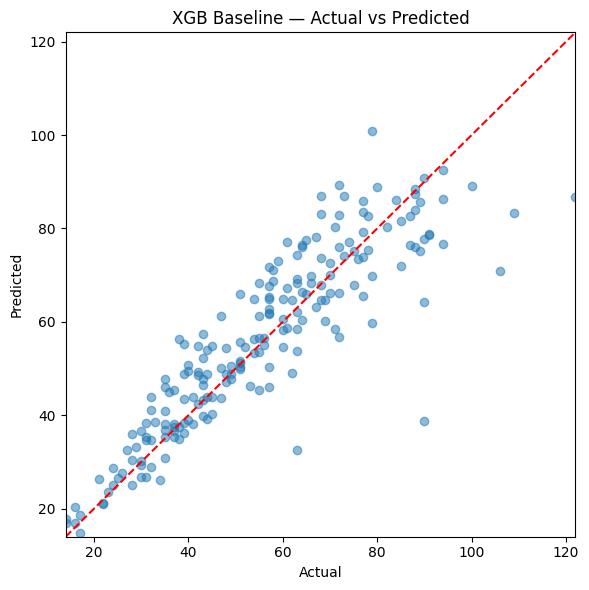

In [37]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--'); plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title("XGB Baseline — Actual vs Predicted")
plt.tight_layout(); plt.show()

In [38]:
r = permutation_importance(pipe_xgb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importances_xgb_base = (pd.DataFrame({
    "feature": base_feature_names,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False).reset_index(drop=True))
display(importances_xgb_base.head(15))

,feature,importance_mean,importance_std
0,Distance_km,1.229153,0.086009
1,Time_of_Day,0.208140,0.031458
2,Courier_Experience_yrs,0.061887,0.015110
3,Preparation_Time_min,0.051697,0.009312
4,Vehicle_Type,0.046895,0.011934
5,Traffic_Level,0.008063,0.005741
6,Weather,0.007611,0.006601


### Tuning

In [39]:
param_dist_xgb = {
    "model__n_estimators":    [300, 500, 700, 900],
    "model__learning_rate":   [0.03, 0.05, 0.08, 0.1],
    "model__max_depth":       [4, 6, 8, 10],
    "model__min_child_weight":[1, 3, 5],
    "model__subsample":       [0.7, 0.85, 1.0],
    "model__colsample_bytree":[0.7, 0.85, 1.0],
    "model__reg_lambda":      [0.0, 0.5, 1.0, 2.0],
    "model__gamma":           [0, 0.5, 1.0]
}

xgb_randcv = RandomizedSearchCV(
    estimator=pipe_xgb, param_distributions=param_dist_xgb,
    n_iter=30, scoring=rmse_scorer, cv=5, random_state=42, n_jobs=-1, verbose=1
)

In [40]:
xgb_randcv.fit(X_train, y_train)
print("Best params (XGB):", xgb_randcv.best_params_)
print("Best CV RMSE (XGB):", -xgb_randcv.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params (XGB): {'model__subsample': 0.7, 'model__reg_lambda': 2.0, 'model__n_estimators': 700, 'model__min_child_weight': 5, 'model__max_depth': 4, 'model__learning_rate': 0.03, 'model__gamma': 0.5, 'model__colsample_bytree': 0.7}
Best CV RMSE (XGB): 11.949008775397141


In [41]:
best_xgb = xgb_randcv.best_estimator_
y_pred_best = best_xgb.predict(X_test)
mae_b, rmse_b, r2_b = mean_absolute_error(
    y_test, y_pred_best), rmse_func(y_test, y_pred_best),
    r2_score(y_test, y_pred_best)
print("\n=== XGBoost (Tuned) — Test ===")
print(f"MAE : {mae_b:,.3f}  |  RMSE: {rmse_b:,.3f}  |  R²: {r2_b:,.3f}")


=== XGBoost (Tuned) — Test ===
MAE : 6.596  |  RMSE: 9.207  |  R²: 0.811


In [42]:
cv_scores_xgb_best = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring=rmse_scorer, n_jobs=-1)
print("XGB Tuned — CV RMSE mean:", (-cv_scores_xgb_best).mean().round(3), "| std:", (-cv_scores_xgb_best).std().round(3))

XGB Tuned — CV RMSE mean: 11.949 | std: 1.055


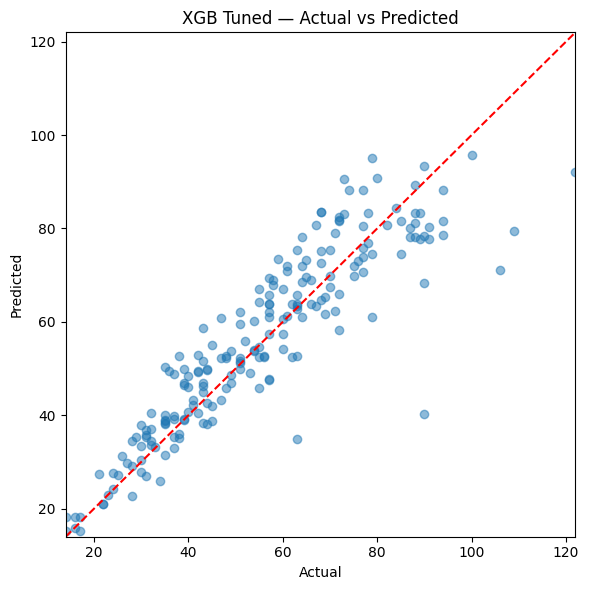

In [43]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
lims = [min(y_test.min(), y_pred_best.min()), max(y_test.max(), y_pred_best.max())]
plt.plot(lims, lims, 'r--'); plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title("XGB Tuned — Actual vs Predicted")
plt.tight_layout(); plt.show()

In [44]:
r = permutation_importance(best_xgb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importances_xgb_tuned = (pd.DataFrame({
    "feature": base_feature_names,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False).reset_index(drop=True))
display(importances_xgb_tuned.head(15))

,feature,importance_mean,importance_std
0,Distance_km,1.261613,0.085043
1,Time_of_Day,0.226592,0.022149
2,Courier_Experience_yrs,0.072999,0.015383
3,Preparation_Time_min,0.055743,0.007226
4,Vehicle_Type,0.051504,0.007019
5,Traffic_Level,0.005203,0.005545
6,Weather,0.005008,0.003339


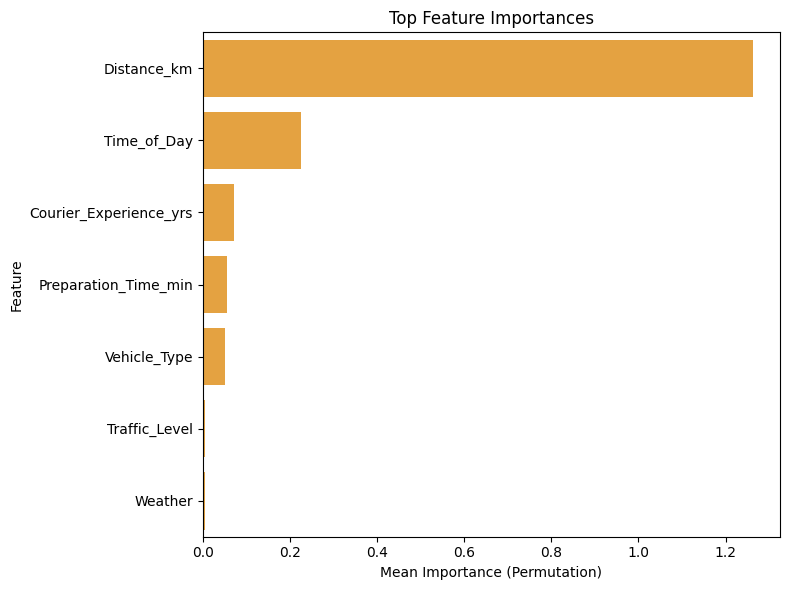

,feature,importance_mean,importance_std
0,Distance_km,1.261613,0.085043
1,Time_of_Day,0.226592,0.022149
2,Courier_Experience_yrs,0.072999,0.015383
3,Preparation_Time_min,0.055743,0.007226
4,Vehicle_Type,0.051504,0.007019


In [53]:
plt.figure(figsize=(8,6))
sns.barplot(data=importances_xgb_tuned.head(10),
            x="importance_mean", y="feature", color="#FFA726")
plt.title("Top Feature Importances")
plt.xlabel("Mean Importance (Permutation)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Tampilkan tabel top 5
display(importances_xgb_tuned.head(5))